# Binary classification in Python using Logistic Regression and CART

## Case: Retention Modeling at Scholastic Travel Company

# Install and load the necessary packages and libraries

In [1]:
# Load the necessary packages and libaries

import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score


import warnings
warnings.filterwarnings("ignore")

# Load the data

In [2]:
# Load the data from the CSV file into the dataframe
df =pd.read_excel("UV7581-XLS-ENG.xlsx", sheet_name='Exhibit 1 -- Data')
df = df.drop("ID", axis='columns')
df = df.iloc[:-3]
# df.tail()

# Exploring the data

Explore the dataset, think about what changes need to be made, create dummy variables as needed.


In [3]:
# Checking what kinds of data we have

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2389 entries, 0 to 2388
Data columns (total 55 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Program.Code                    2389 non-null   object        
 1   From.Grade                      2262 non-null   float64       
 2   To.Grade                        2239 non-null   float64       
 3   Group.State                     2389 non-null   object        
 4   Is.Non.Annual.                  2389 non-null   float64       
 5   Days                            2389 non-null   float64       
 6   Travel.Type                     2389 non-null   object        
 7   Departure.Date                  2389 non-null   datetime64[ns]
 8   Return.Date                     2389 non-null   datetime64[ns]
 9   Deposit.Date                    2389 non-null   datetime64[ns]
 10  Special.Pay                     470 non-null    object        
 11  Tuit

In [4]:
# df['From.Grade'].value_counts()

In [5]:
# Recode grade levels

df['School.level'] = np.select(
    [df['From.Grade'] < 6, df['From.Grade'].between(6, 8), df['From.Grade'] >= 9],
    ['Elementary School', 'Middle School', 'High School']
)

print(df['School.level'].value_counts())


Middle School        1862
Elementary School     259
High School           141
0                     127
Name: School.level, dtype: int64


In [6]:
# Get rid of extraneous variables
df = df.drop(["From.Grade","To.Grade", "Early.RPL","Latest.RPL","DifferenceTraveltoFirstMeeting",
              "DifferenceTraveltoLastMeeting","FirstMeeting","LastMeeting","MDR.Low.Grade",
              "MDR.High.Grade","Total.School.Enrollment","FPP.to.School.enrollment",
              "Initial.System.Date","CRM.Segment"], axis='columns')
df = df.drop(df.select_dtypes(include='datetime64[ns]').columns, axis=1)

In [7]:
# Recode Is.Non.Annual for easier interpretation
df['Is.Annual.'] = 1-df['Is.Non.Annual.']
df = df.drop("Is.Non.Annual.", axis='columns')

In [8]:
# Check number of observations per category for all variables

# for column in df.columns:
#     value_counts = df[column].value_counts()
#     print(f"Value counts for column '{column}':\n{value_counts}\n")


In [9]:
# Create a mapping between states and regions
state_to_region = {
    'AL': 'Southeast',
    'AK': 'West',
    'AZ': 'West',
    'AR': 'Southeast',
    'CA': 'West',
    'CO': 'West',
    'CT': 'Northeast',
    'DE': 'Northeast',
    'FL': 'Southeast',
    'GA': 'Southeast',
    'HI': 'West',
    'ID': 'West',
    'IL': 'Midwest',
    'IN': 'Midwest',
    'IA': 'Midwest',
    'KS': 'Midwest',
    'KY': 'Southeast',
    'LA': 'Southeast',
    'ME': 'Northeast',
    'MD': 'Northeast',
    'MA': 'Northeast',
    'MI': 'Midwest',
    'MN': 'Midwest',
    'MS': 'Southeast',
    'MO': 'Midwest',
    'MT': 'West',
    'NE': 'Midwest',
    'NV': 'West',
    'NH': 'Northeast',
    'NJ': 'Northeast',
    'NM': 'West',
    'NY': 'Northeast',
    'NC': 'Southeast',
    'ND': 'Midwest',
    'OH': 'Midwest',
    'OK': 'South',
    'OR': 'West',
    'PA': 'Northeast',
    'RI': 'Northeast',
    'SC': 'Southeast',
    'SD': 'Midwest',
    'TN': 'Southeast',
    'TX': 'South',
    'UT': 'West',
    'VT': 'Northeast',
    'VA': 'Southeast',
    'WA': 'West',
    'WV': 'Southeast',
    'WI': 'Midwest',
    'WY': 'West',
    'DC': 'Northeast',  # Washington, D.C.
}

df['Group.Region'] = df['Group.State'].replace(state_to_region)
df.head()

,Program.Code,Group.State,Days,Travel.Type,Special.Pay,Tuition,FRP.Active,FRP.Cancelled,FRP.Take.up.percent.,Cancelled.Pax,...,GroupGradeType,MajorProgramCode,SingleGradeTripFlag,FPP.to.PAX,Num.of.Non_FPP.PAX,SchoolSizeIndicator,Retained.in.2012.,School.level,Is.Annual.,Group.Region
0,HS,CA,1.0,A,NaN,424.0,25.0,3.0,0.424,3.0,...,K->Elementary,H,1.0,0.936508,4.0,L,1.0,Elementary School,1.0,West
1,HC,AZ,7.0,A,CP,2350.0,9.0,9.0,0.409,11.0,...,Middle->Middle,H,1.0,0.880000,3.0,L,1.0,Middle School,1.0,West
2,HD,FL,3.0,A,NaN,1181.0,17.0,6.0,0.708,6.0,...,Middle->Middle,H,1.0,0.888889,3.0,L,1.0,Middle School,1.0,Southeast
3,HN,VA,3.0,B,NaN,376.0,0.0,0.0,0.000,1.0,...,Undefined->Undefined,H,0.0,1.000000,0.0,NaN,0.0,High School,0.0,Southeast
4,HD,FL,6.0,T,NaN,865.0,40.0,8.0,0.494,9.0,...,Middle->Middle,H,0.0,0.910112,8.0,M-L,0.0,Middle School,1.0,Southeast


In [10]:
# Combine rate categories ("levels")

# Here is a custom function: CombineRareCategories
# this function has two arguments: the name of the dataframe (data) and the minimal number of datapoints to remain a separate category (mincount)
# this function will loop through all the columns in the dataframe, and will combine all categories that appear in the data less than mincount number of times into (Other)
# ['category','object','bool']

def CombineRareCategories(data, mincount):
    for col in data.columns:
        if (type(data[col][0]) == str):
            for index, row in pd.DataFrame(data[col].value_counts()).iterrows():
                if ( row[0] < mincount):
                    df[col].replace(index, 'Other_' + col, inplace = True)
                else:
                    None

# let's apply this function to our data with mincount=10
CombineRareCategories(df, 10)

df.head(10) #let's check the result
df['Program.Code'].value_counts().to_frame()

,Program.Code
HD,1430
HC,274
HS,131
CD,114
HN,73
SK,68
HVP,62
Other_Program.Code,58
SC,46
ST,28


## Dealing with missing data

In [11]:
# Let's check if we have any missing data

#  Print out count of missing data by variable
print(pd.DataFrame(df).isna().sum() )

#  Print out total count of missing data
#print("Total count of missing data:", pd.DataFrame(df).isna().sum().sum() )

Program.Code                      0
Group.State                       0
Days                              0
Travel.Type                       0
Special.Pay                    1919
Tuition                           0
FRP.Active                        0
FRP.Cancelled                     0
FRP.Take.up.percent.              0
Cancelled.Pax                     0
Total.Discount.Pax                0
Poverty.Code                    599
Region                            0
School.Type                       0
Parent.Meeting.Flag               0
Income.Level                     62
EZ.Pay.Take.Up.Rate               0
School.Sponsor                    0
SPR.Product.Type                  0
SPR.New.Existing                  0
FPP                               0
Total.Pax                         0
SPR.Group.Revenue                 0
NumberOfMeetingswithParents       0
SchoolGradeTypeLow                0
SchoolGradeTypeHigh               0
SchoolGradeType                   0
DepartureMonth              

In [12]:
#Check what is going on with Special Pay
df['Special.Pay'].unique()
df['Poverty.Code'].unique()
df['SchoolSizeIndicator'].unique()
df['Income.Level'].unique()

array(['Q', 'A', 'O', nan, 'C', 'I', 'G', 'K', 'L', 'Other_Income.Level',
       'N', 'H', 'E', 'M', 'P', 'J', 'Z', 'B', 'F', 'D'], dtype=object)

In [13]:
# Replace nan in Special.Pay with 'None'
df['Special.Pay'] = df['Special.Pay'].fillna('None')
df['Poverty.Code'] = df['Poverty.Code'].fillna('None')
# df['Poverty.Code'] = df['Poverty.Code'].replace("0", "None")
df['SchoolSizeIndicator'] = df['SchoolSizeIndicator'].fillna('Unknown')
df['Income.Level'] = df['Income.Level'].fillna("Z")

In [14]:
# Check for missing data again"

# print(pd.DataFrame(df).isna().sum() )

In [15]:
# Creating dummy variables for non-numbers. Which variables should we include?

df = pd.get_dummies(data=df, columns = ['Program.Code','School.level','Group.Region','Travel.Type',
                                        'Poverty.Code','School.Type','Special.Pay',
                                        # 'Region',
                                        'DepartureMonth','Income.Level'], drop_first=True)

# If you have a lot of variables in your code, use the line below to
# remove the limit on the number of columns; by default only 20 are shown:
#pd.options.display.max_columns = None

# df.head()

In [16]:
pd.options.display.max_columns = None
df.head()

,Group.State,Days,Tuition,FRP.Active,FRP.Cancelled,FRP.Take.up.percent.,Cancelled.Pax,Total.Discount.Pax,Region,Parent.Meeting.Flag,EZ.Pay.Take.Up.Rate,School.Sponsor,SPR.Product.Type,SPR.New.Existing,FPP,Total.Pax,SPR.Group.Revenue,NumberOfMeetingswithParents,SchoolGradeTypeLow,SchoolGradeTypeHigh,SchoolGradeType,GroupGradeTypeLow,GroupGradeTypeHigh,GroupGradeType,MajorProgramCode,SingleGradeTripFlag,FPP.to.PAX,Num.of.Non_FPP.PAX,SchoolSizeIndicator,Retained.in.2012.,Is.Annual.,Program.Code_CD,Program.Code_HC,Program.Code_HD,Program.Code_HG,Program.Code_HN,Program.Code_HO,Program.Code_HS,Program.Code_HVP,Program.Code_IC,Program.Code_Other_Program.Code,Program.Code_SC,Program.Code_SG,Program.Code_SK,Program.Code_SM,Program.Code_ST,School.level_Elementary School,School.level_High School,School.level_Middle School,Group.Region_Northeast,Group.Region_Other_Group.Region,Group.Region_South,Group.Region_Southeast,Group.Region_West,Travel.Type_B,Travel.Type_Other_Travel.Type,Poverty.Code_B,Poverty.Code_C,Poverty.Code_D,Poverty.Code_E,Poverty.Code_None,Poverty.Code_Other_Poverty.Code,School.Type_Catholic,School.Type_PUBLIC,School.Type_Private non-Christian,Special.Pay_FR,Special.Pay_None,Special.Pay_SA,DepartureMonth_February,DepartureMonth_June,DepartureMonth_March,DepartureMonth_May,DepartureMonth_Other_DepartureMonth,Income.Level_B,Income.Level_C,Income.Level_D,Income.Level_E,Income.Level_F,Income.Level_G,Income.Level_H,Income.Level_I,Income.Level_J,Income.Level_K,Income.Level_L,Income.Level_M,Income.Level_N,Income.Level_O,Income.Level_Other_Income.Level,Income.Level_P,Income.Level_Q,Income.Level_Z
0,CA,1.0,424.0,25.0,3.0,0.424,3.0,4.0,Southern California,1.0,0.170,1.0,CA History,EXISTING,59.0,63.0,424.0,1.0,Elementary,Elementary,Elementary->Elementary,K,Elementary,K->Elementary,H,1.0,0.936508,4.0,L,1.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,AZ,7.0,2350.0,9.0,9.0,0.409,11.0,3.0,Other,1.0,0.091,0.0,East Coast,EXISTING,22.0,25.0,2350.0,2.0,Middle,Middle,Middle->Middle,Middle,Middle,Middle->Middle,H,1.0,0.880000,3.0,L,1.0,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,FL,3.0,1181.0,17.0,6.0,0.708,6.0,3.0,Other,1.0,0.042,0.0,East Coast,EXISTING,24.0,27.0,1181.0,1.0,Middle,Middle,Middle->Middle,Middle,Middle,Middle->Middle,H,1.0,0.888889,3.0,L,1.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,VA,3.0,376.0,0.0,0.0,0.000,1.0,0.0,Other,0.0,0.000,0.0,East Coast,EXISTING,18.0,18.0,376.0,0.0,High,High,High->High,Undefined,Undefined,Undefined->Undefined,H,0.0,1.000000,0.0,Unknown,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,FL,6.0,865.0,40.0,8.0,0.494,9.0,8.0,Other,1.0,0.383,0.0,East Coast,EXISTING,81.0,89.0,865.0,1.0,Middle,Middle,Middle->Middle,Middle,Middle,Middle->Middle,H,0.0,0.910112,8.0,M-L,0.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
# drop all remaining object type variables from df
object_cols = [col for col in df.columns if df[col].dtype == "object"]
df = df.drop(object_cols, axis=1)


# Defining the vector of target (y) and matrix of features (X)

In [18]:
y = df['Retained.in.2012.']
X = df.drop(columns = ['Retained.in.2012.'])

# Split X and y into training and testing

In [19]:
from sklearn.model_selection import train_test_split

# split the data randomly into 80% train and 20% test samples
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify=y, random_state = 42)
# IMPORTANT: these samples are stratified, i.e., the proportion of retained and not-retained customers is the same in both

# Let's check the results
#print(X_train.head())
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1911, 78)
(478, 78)
(1911,)
(478,)


# Train a model on the training data, Use it to predict the values in the testing data

## Logistic regression

In [20]:
# define the model and call it classifier_LR
classifier_LR = LogisticRegression()

# train classifier_LR on the training data
classifier_LR.fit(X_train, y_train)

# This is a regression, so it has coefficients -- let's see them
# Note, there is no easy way to show significance, etc. with sklearn

summary = pd.DataFrame([X_test.columns,classifier_LR.coef_[0]]).transpose().sort_values(by = 1, ascending = False)
summary.columns = ['Variable','Coefficient']
print("Total number of coefficients:", len(summary),"\n")

print('Highest Coefficients:')
print(summary.head(10))

#Q: Should we worry about lowest coefficients?
print('Lowest Coefficients:')
print(summary.tail(10))

Total number of coefficients: 78 

Highest Coefficients:
                             Variable Coefficient
14                SingleGradeTripFlag    1.464735
17                         Is.Annual.    1.089809
35         School.level_Middle School    0.289677
9                      School.Sponsor     0.22256
75                     Income.Level_P    0.203733
40                  Group.Region_West    0.133581
19                    Program.Code_HC    0.130648
51  School.Type_Private non-Christian    0.128182
58                 DepartureMonth_May    0.112752
76                     Income.Level_Q    0.107143
Lowest Coefficients:
                       Variable Coefficient
41                Travel.Type_B   -0.105894
25             Program.Code_HVP   -0.123022
44               Poverty.Code_C   -0.139729
43               Poverty.Code_B   -0.160302
50           School.Type_PUBLIC   -0.164688
68               Income.Level_J   -0.165954
53             Special.Pay_None   -0.201309
13  NumberOfMeetings

In [21]:
# Use the trained model to predict testing data
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1] # probabilities


## Evaluate the model

### Calculate and plot the metrics for our model

In [22]:
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

We believe in this case we want higher accuracy, so we want to define the threshold by geting highest accuracy.


The Confusion Matrix with the Best Threshold which can get best Accuracy:


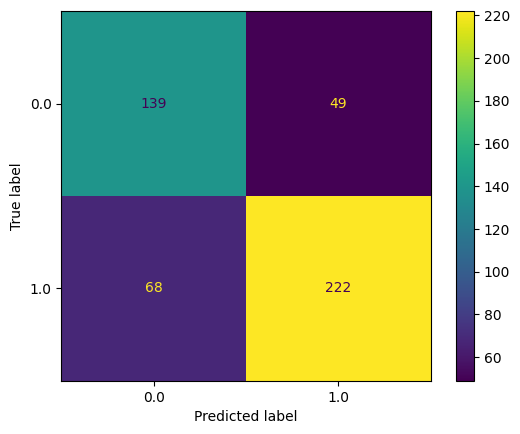

Best Threshold: 0.6199999999999998
Best Accuracy: 0.7552301255230126
Precision: 0.8191881918819188
Recall: 0.7655172413793103


In [23]:
# Initialize variables to keep track of the best accuracy and corresponding threshold
max_accuracy = 0
best_threshold = None
best_fig_cm = None
best_y_pred = None

# Loop over each threshold value
for i in np.arange(0.1, 1.0, 0.01):

    # Select the threshold value
    class_threshold = i

    # Apply the threshold rule to classify
    y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Check if this threshold has a higher accuracy than the current max accuracy
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_threshold = class_threshold
        best_y_pred = y_pred

# Calculate confusion matrix for the best threshold
cm = confusion_matrix(y_test, best_y_pred, labels=classifier_LR.classes_)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier_LR.classes_)
best_fig_cm = plt.figure()
disp_cm.plot()
plt.close(best_fig_cm)

print("The Confusion Matrix with the Best Threshold which can get best Accuracy:")
# Calculate precision and recall for the best threshold
precision = precision_score(y_test, best_y_pred)
recall = recall_score(y_test, best_y_pred)

plt.show(best_fig_cm)

# Print the best threshold and display the best confusion matrix
print("Best Threshold:", best_threshold)
print("Best Accuracy:", max_accuracy)
print("Precision:", precision)
print("Recall:", recall)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels={'x':'1 - Specificity', 'y':'Sensitivity'}
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.show()



# Decision Trees

In [24]:
from sklearn.tree import DecisionTreeClassifier
class_threshold = 0.5
# Define a Decision Tree model and call it classifier_DT
#classifier_DT = DecisionTreeClassifier(random_state=42) # random_state -- is same as random seed, neede to get the same result every time we rerun
classifier_DT = DecisionTreeClassifier(max_leaf_nodes = 6,  random_state=42)

#Hyper-parameters to explore for fine-tuning the tree:
#min_samples_split – Minimum number of samples a node must possess before splitting.
#min_samples_leaf – Minimum number of samples a leaf node must possess.
#min_weight_fraction_leaf – Minimum fraction of the sum total of weights required to be at a leaf node.
#max_leaf_nodes – Maximum number of leaf nodes a decision tree can have.
#max_features – Maximum number of features that are taken into the account for splitting each node.

# Train the model classifier_DT on the training data
classifier_DT.fit(X_train, y_train)
y_pred_prob = classifier_DT.predict_proba(X_test)[:,1] # probabilities

y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

In [25]:
# Visualizing the resultant tree
import matplotlib.pyplot as plt
from sklearn import tree

# model metrics
from sklearn.metrics import ConfusionMatrixDisplay

Best Model Metrics:
Accuracy: 0.7824267782426778
Precision: 0.8120805369127517
Recall: 0.8344827586206897
AUC: 0.8208914159941307
Best Leaf Node: 8


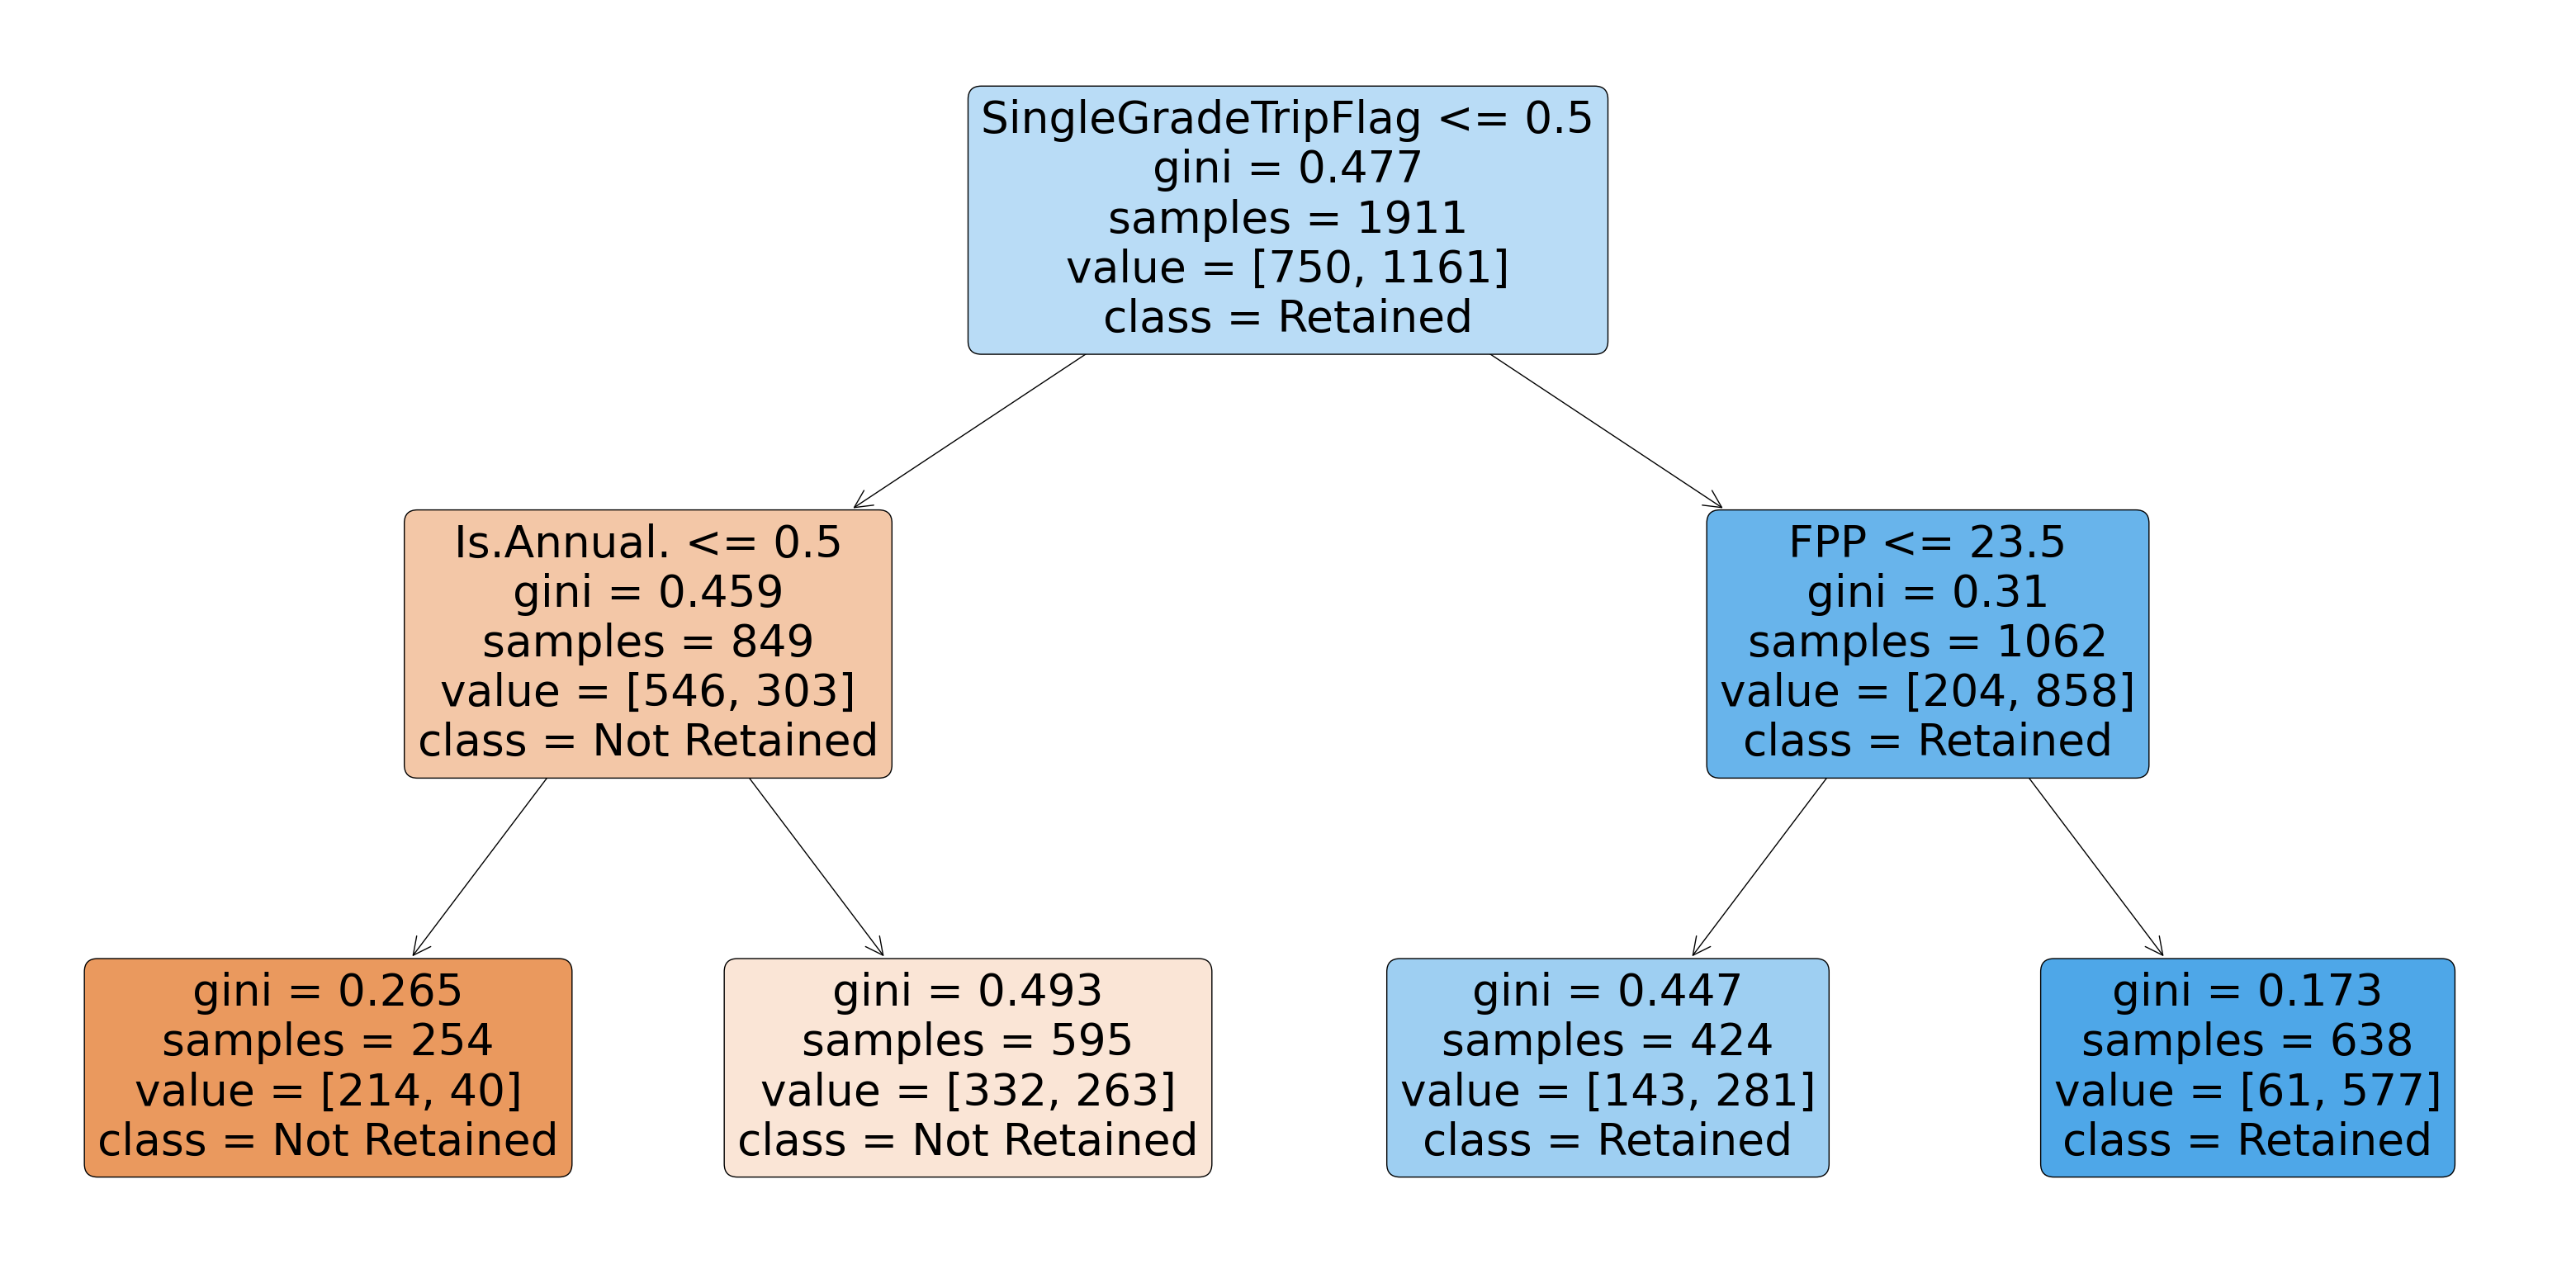

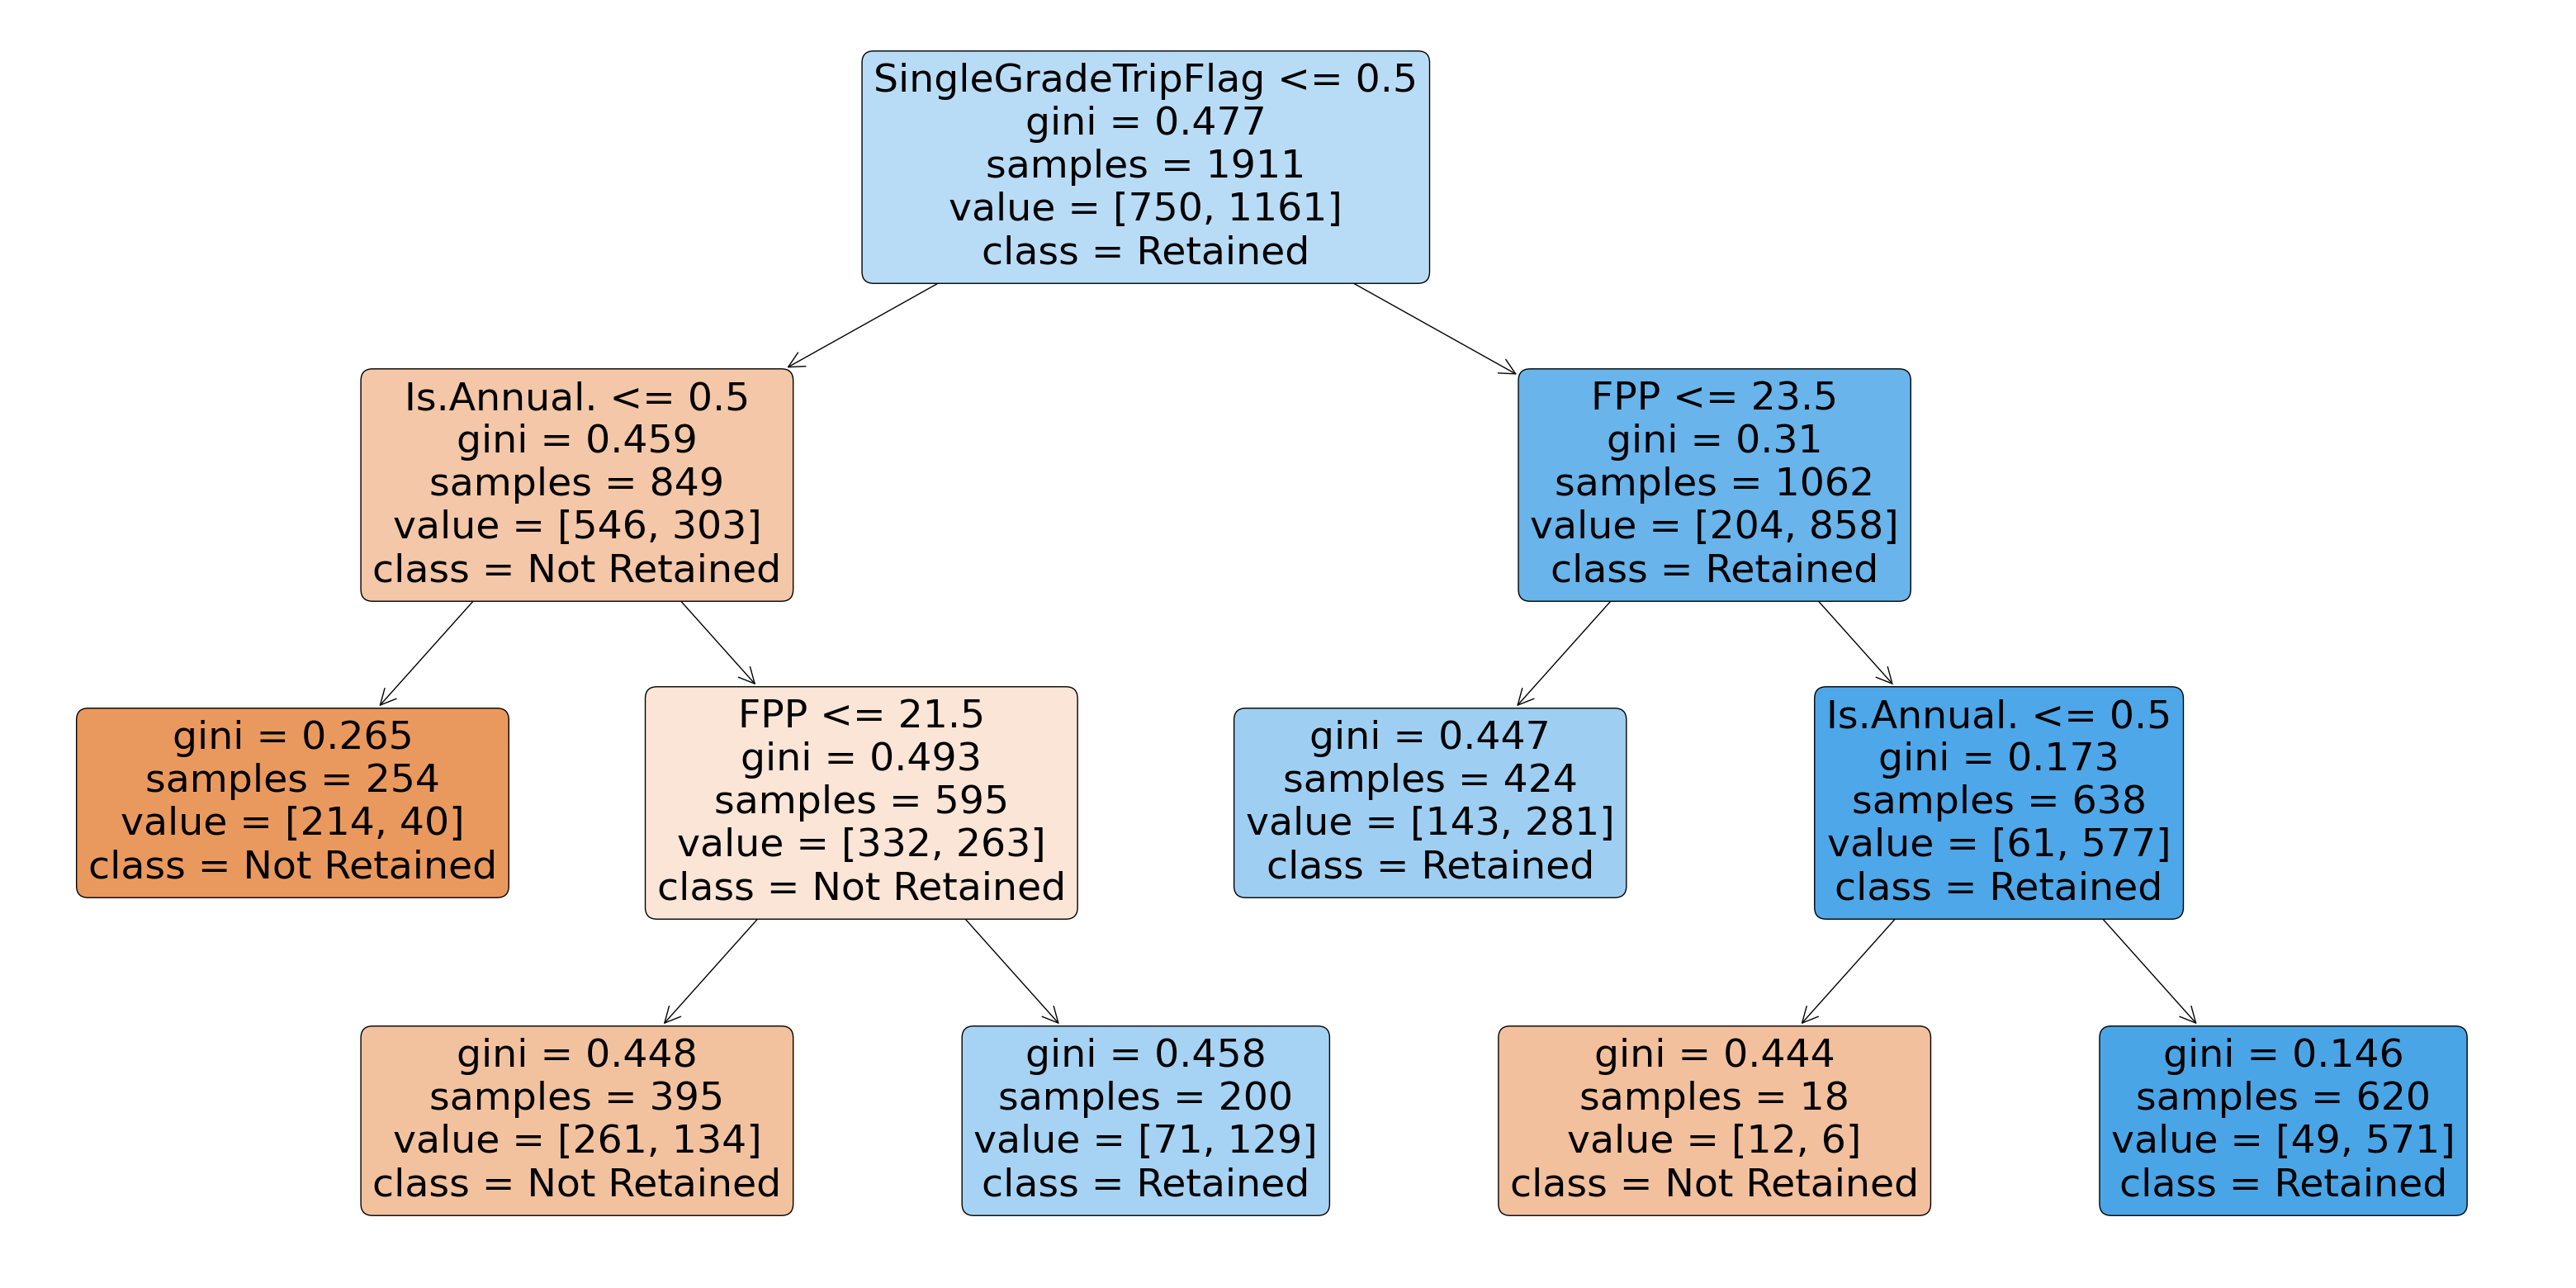

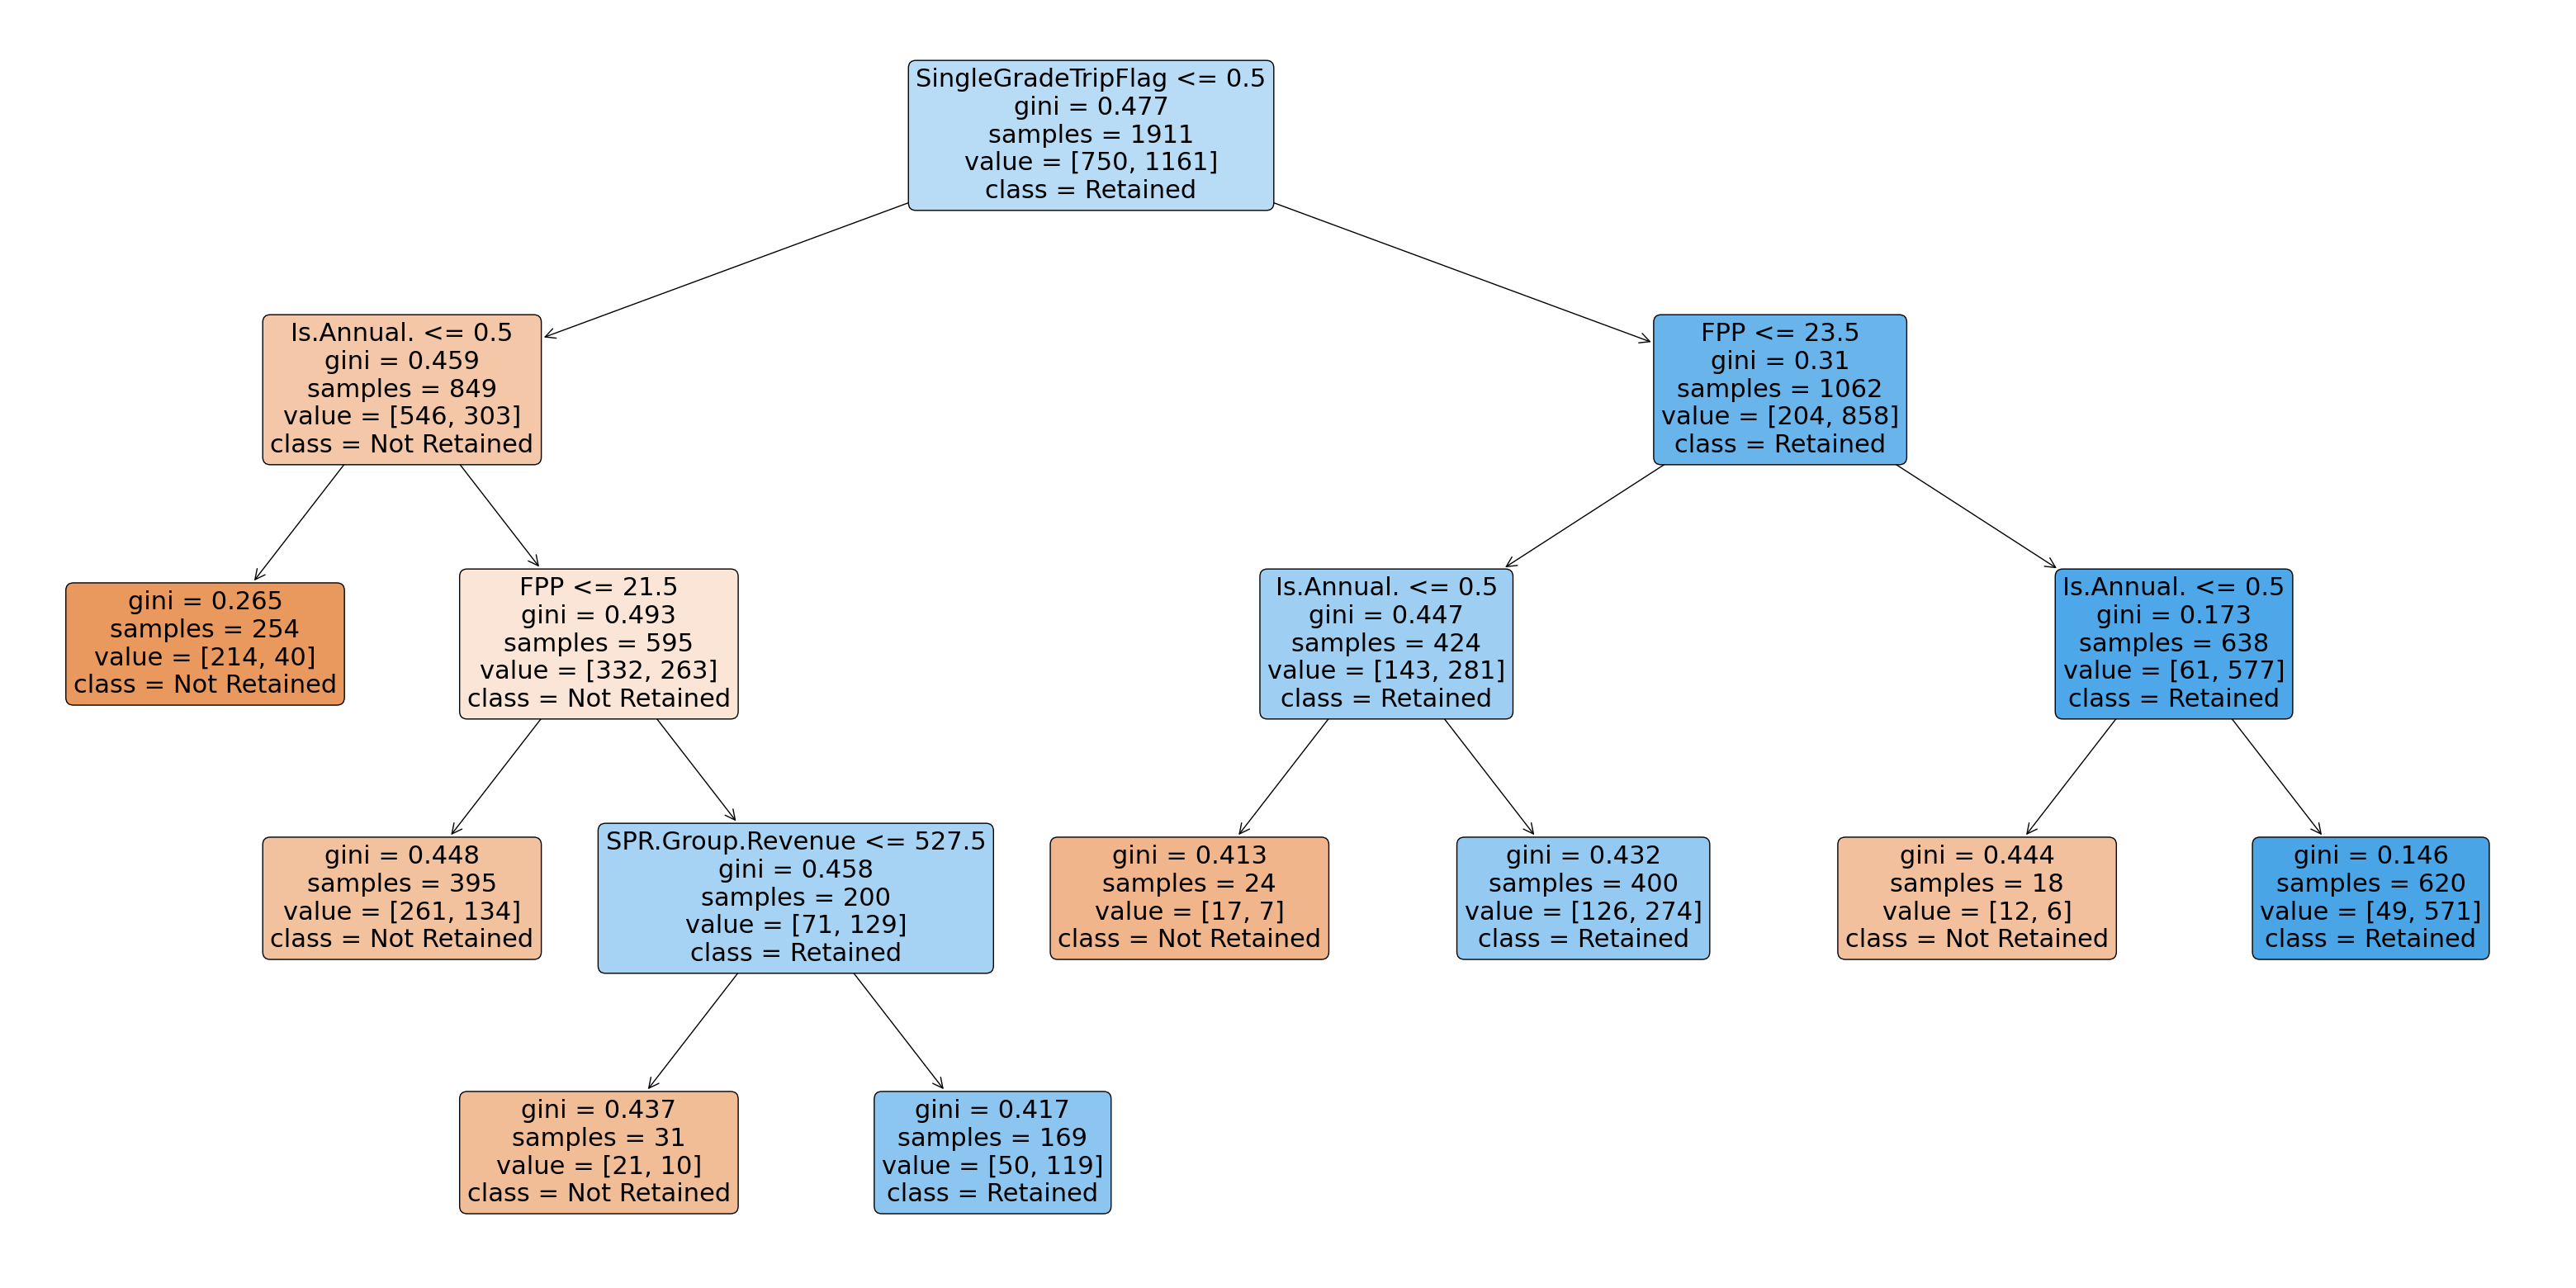

<Figure size 800x600 with 0 Axes>

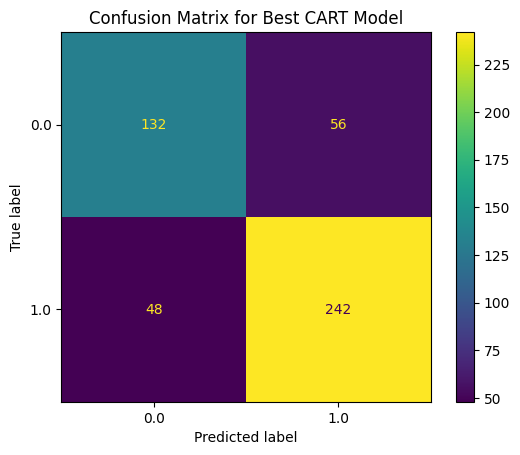

In [27]:
# Define hyperparameters to explore
max_leaf_nodes_values = [4, 6, 8]
random_state_value = 42

# Initialize variables to keep track of the best model and its performance
best_model = None
best_accuracy = 0
best_precision = 0
best_recall = 0
best_auc = 0
best_confusion_matrix = None
best_max_leaf_nodes = None  # Variable to keep track of the best leaf node value
best_tree_figure = None  # Variable to keep track of the best tree figure

# Iterate over hyperparameters
for max_leaf_nodes in max_leaf_nodes_values:
    # Define the Decision Tree model with current hyperparameters
    classifier_DT = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=random_state_value)

    # Train the model
    classifier_DT.fit(X_train, y_train)

    # Make predictions
    y_pred_prob = classifier_DT.predict_proba(X_test)[:, 1]
    y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)

    # If current model is better than the best model found so far, update the best model and its metrics
    if accuracy > best_accuracy:
        best_model = classifier_DT
        best_accuracy = accuracy
        best_precision = precision
        best_recall = recall
        best_auc = auc
        best_max_leaf_nodes = max_leaf_nodes  # Update the best leaf node value
        cm = confusion_matrix(y_test, y_pred, labels=classifier_DT.classes_)
        best_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier_DT.classes_)

        # Generate the tree figure for the best model
        best_tree_figure = plt.figure(figsize=(40, 20))
        tree.plot_tree(classifier_DT, feature_names=X_train.columns, class_names=['Not Retained', 'Retained'],
                  filled=True, rounded=True)

# Print best model's metrics and the best leaf node value
print("Best Model Metrics:")
print("Accuracy:", best_accuracy)
print("Precision:", best_precision)
print("Recall:", best_recall)
print("AUC:", best_auc)
print("Best Leaf Node:", best_max_leaf_nodes)

# Plot best model's confusion matrix
plt.figure(figsize=(8, 6))
best_confusion_matrix.plot()
plt.title('Confusion Matrix for Best CART Model')
plt.show()

# Plot ROC curve for best model
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={best_auc:.4f})',
    labels={'x': '1 - Specificity', 'y': 'Sensitivity'}
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.show()

# Show the best tree figure
plt.show(best_tree_figure)

## Over Fitting Test

In [28]:
# Tuning hyper-parameter max_leaf_nodes

n_max_leaf_nodes = range(5,40) # Let's train the models with 5, 6, 7, ... 40 leafs

fig = px.scatter()

# for each model calculate AUC for testing
array = []
for n in n_max_leaf_nodes:

    classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = n)
    classifier_DT = classifier_DT.fit(X_train, y_train)

    y_pred_prob = classifier_DT.predict_proba(X_test)[:,1]
    y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

    array.append([n,roc_auc_score(y_test, y_pred_prob)])

# plot the testing set AUCs
array = pd.DataFrame(array)
fig.add_scatter(x = array[0], y = array[1], name = 'Testing Data', mode = 'markers')


# now for each model calculate AUC on training
array = []
for n in n_max_leaf_nodes:

    classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = n)
    classifier_DT = classifier_DT.fit(X_train, y_train)

    y_pred_prob = classifier_DT.predict_proba(X_train)[:,1]
    y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

    array.append([n,roc_auc_score(y_train, y_pred_prob)])

# plot the training set AUCs
array = pd.DataFrame(array)
fig.add_scatter(x = array[0], y = array[1], name = 'Training Data', mode = 'markers')

fig.update_layout(
    title="Illustrate Overfitting",
    xaxis_title="Number of Leaves",
    yaxis_title="AUC",
)


# Insights and Conclusion

*Compare and contrast the output of the Logistic Regression Model and the CART Model. Pick one model that you would use to make predictions. Why do you select this model? What performance metric is most important to you? How do you make the choice between higher specificity vs higher sensitivity? Which is more important for this business application?*

**How we figure out each model**: We tried to figure out the optimized threshold (threshold = 0.62) for logistic model to get the highest accuracy, since in the case, they want a more accurate model, didn't talk about information of buget limit. We get the best leaf note = 8 for the tree model in the same purpose.


**The model we choose and why**: Since the AUC for Decision Tree model (0.8209) is higher than the AUC for the logistic regression model (0.8016), we prefer to use the tree model with 8 leaf nodes.


**What performance metric is most important to you?**: Accuracy and AUC (ROC Curve)


**Specificity vs sensitivity**: The choice between higher specificity and higher sensitivity in a predictive model depends on the company's budget and target. If the goal is to maximize revenue by retaining as many schools as possible in 2012, prioritizing higher sensitivity is a better strategy. This ensures accurate identification of schools likely to participate again, enabling targeted retention strategies. Conversely, if resources are limited and prioritization is needed, higher specificity becomes more important. This ensures accurate identification of schools unlikely to participate, allowing focused resource allocation for retaining schools with the highest potential for participation.


**Which is more important for this business application?**:

In the context of the Scholastic Travel Company (STC), the decision tree models aim at enhancing the prediction accuracy for customer retention, specifically whether a group will return the next year​​. Achieving higher sensitivity in the model is crucial for this objective, as it implies a better ability to correctly identify true positives, and increase revenue, i.e., groups that will indeed rebook.

By accurately predicting customer rebooking behavior, these models directly contribute to cost reduction in several ways:

*Targeted Marketing*: By identifying characteristics of groups most likely to return, STC can design more focused marketing campaigns, allocating resources to prospects with the highest probability of rebooking, thus saving on broader, less effective marketing efforts.

*Resource Optimization*: Understanding which groups are more likely to return allows for more efficient allocation of resources, both in terms of customer service and trip planning, ensuring that efforts are concentrated on maintaining relationships with high-potential groups.

*Enhanced Customer Experience*: By predicting the likelihood of return, STC can tailor the travel experience to meet the needs and preferences of repeat groups, potentially increasing customer satisfaction and loyalty, which in turn can lead to word-of-mouth referrals and reduced acquisition costs.

*Strategic Planning*: Accurate predictions assist in forecasting revenue and making informed decisions regarding capacity, staffing, and other operational aspects, leading to more efficient management and reduced overheads.